In [1]:
#Preliminaries
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
import math
from sklearn.utils import resample
from scipy import percentile
# import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import pyplot as plt
from google.colab import files


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# #Import data, must do manually to select csv files from home directory
upload1 = files.upload()


Saving EM Factors.csv to EM Factors (3).csv
Saving EM Funds.csv to EM Funds (3).csv


In [4]:
for fn in upload1.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name='EM Funds.csv', length=len(upload1[fn])))
for fn in upload1.keys():  
  print('User uploaded file "{name}" with length {length} bytes'.format(name='EM Factors.csv', length=len(upload1[fn])))

User uploaded file "EM Funds.csv" with length 16034 bytes
User uploaded file "EM Funds.csv" with length 1443391 bytes
User uploaded file "EM Factors.csv" with length 16034 bytes
User uploaded file "EM Factors.csv" with length 1443391 bytes


In [5]:
import io
Y_raw = pd.read_csv(io.StringIO(upload1['EM Funds.csv'].decode('utf-8')), index_col='Dates')
Y_raw.index = pd.to_datetime(Y_raw.index, format = '%m/%d/%Y') + pd.offsets.MonthEnd(0)
X_raw = pd.read_csv(io.StringIO(upload1['EM Factors.csv'].decode('utf-8')), index_col='Dates')
X_raw.index = pd.to_datetime(X_raw.index, format = '%m/%d/%Y') + pd.offsets.MonthEnd(0)
X_raw.shape, Y_raw.shape

((214, 9), (214, 812))

In [6]:
# X_input = pd.read_csv('FamaFrenchOct2017.csv', index_col = 'date')
# X_input.index = pd.to_datetime(X_input.index, format = '%Y%m') + pd.offsets.MonthEnd(0)
# date_start = '20010131'
# date_end = '20181031'
# dates = pd.date_range(start=date_start, end=date_end, freq='M')
# Y_raw = pd.DataFrame(Y_rand, index=dates)
# Y_rand['Dates'] = pd.to_datetime(Y_rand['Dates'])
# mfund_names
#Create lists of Fama-French factors and mutual fund symbols
min_number_of_obs = 120
Y_all = Y_raw.loc[:, (Y_raw.count().values > min_number_of_obs)].drop(['ABIEX'], axis=1)
Y_all = Y_all.sub(X_raw['RF'],axis=0)
df1 =Y_all.columns.get_values()
funds=df1.tolist()
df2=X_raw.columns.get_values()
factors=df2.tolist()
factors_remove = ['MXEF', 'M1EF000V', 'M1EF000G', 'MXEFLC','MXEFSC', 'RF']
for items in factors_remove:
  factors.remove(items)

# mfund_names
#factors, mfund_names
Y_all.shape, len(funds)

((214, 205), 205)

In [7]:
# Y_rand=Y_rand.drop('Dates')
Y_all.shape, Y_all.index

((214, 205),
 DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
                '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
                '2001-09-30', '2001-10-31',
                ...
                '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
                '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
                '2018-09-30', '2018-10-31'],
               dtype='datetime64[ns]', name='Dates', length=214, freq='M'))

In [8]:
X_mat=X_raw[factors]
# X_mat.loc[:,0] = pd.Series(np.ones(X_mat.shape[0]), index=X_mat.index)
X_mat.insert(0, 'Ones', float(1))
X_mat.shape, X_mat.index, X_mat.dtypes

((214, 4),
 DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
                '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
                '2001-09-30', '2001-10-31',
                ...
                '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
                '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
                '2018-09-30', '2018-10-31'],
               dtype='datetime64[ns]', name='Dates', length=214, freq='M'),
 Ones    float64
 EMRF    float64
 HML     float64
 SMB     float64
 dtype: object)

## 1. Constructing matrix of dependent variables (fund returns) and explanatory variables (factor returns)

In [0]:
#Initialize parameters
# date_start = '20010101'
# date_end = '20181001'
# dates = pd.date_range(date_start, periods=m, freq='MS')
# fund_names=['Fund1',	'Fund2',	'Fund3',	'Fund4',	'Fund5']
# fund_names=['Fund1',	'Fund2',	'Fund3',	'Fund4',	'Fund5',	'Fund6',	'Fund7',	'Fund8',	'Fund9',	'Fund10',	'Fund11',	'Fund12',	'Fund13',	'Fund14',	'Fund15',	'Fund16',	'Fund17',	'Fund18',	'Fund19',	'Fund20',	'Fund21',	'Fund22',	'Fund23',	'Fund24',	'Fund25',	'Fund26',	'Fund27',	'Fund28',	'Fund29',	'Fund30',	'Fund31',	'Fund32',	'Fund33',	'Fund34',	'Fund35',	'Fund36',	'Fund37',	'Fund38',	'Fund39',	'Fund40',	'Fund41',	'Fund42',	'Fund43',	'Fund44',	'Fund45',	'Fund46',	'Fund47',	'Fund48',	'Fund49',	'Fund50',	'Fund51',	'Fund52',	'Fund53',	'Fund54',	'Fund55',	'Fund56',	'Fund57',	'Fund58',	'Fund59',	'Fund60',	'Fund61',	'Fund62',	'Fund63',	'Fund64',	'Fund65',	'Fund66',	'Fund67',	'Fund68',	'Fund69',	'Fund70',	'Fund71',	'Fund72',	'Fund73',	'Fund74',	'Fund75',	'Fund76',	'Fund77',	'Fund78',	'Fund79',	'Fund80',	'Fund81',	'Fund82',	'Fund83',	'Fund84',	'Fund85',	'Fund86',	'Fund87',	'Fund88',	'Fund89',	'Fund90',	'Fund91',	'Fund92',	'Fund93',	'Fund94',	'Fund95',	'Fund96',	'Fund97',	'Fund98',	'Fund99',	'Fund100',
# ]
#Simulate fund observations of differing lengths and start dates, as real data will have
# Y_rand = np.empty((m,n))*np.nan
# for item in range(n):
#   plug=[np.random.randint(m//4),np.random.randint(m-m//4)]
#   Y_rand[plug[0]: plug[0]+plug[1], item]=np.random.rand(plug[1])
#   del plug
# Y_raw = pd.DataFrame(Y_rand, index=dates, columns=fund_names)
# X_mat = pd.DataFrame(np.random.rand(m,h+1), index=dates, columns=column_names)
# Y_all = Y_raw.sub(X_raw['RF'],axis=0)
np.random.seed(2)
m = X_mat.shape[0]  # number of observations
n = Y_all.shape[1]  # number of funds with return series
h = X_mat.shape[1]-1 # risk factors
s = 100 # number of simulations
column_names=['Mkt-RF','SMB','HML', 'RF']
factor_names=['Alpha','Mkt-RF','SMB','HML']
sim_factors=['Mkt-RF', 'SMB', 'HML']
one_name=['Alpha']
orig_coeffs = pd.DataFrame(np.zeros(shape = (h+1, n)), index=factor_names, columns = funds)/0
orig_SE_coeffs = pd.DataFrame(np.zeros(shape = (h+1, n)), index=factor_names, columns = funds)/0
constructed_X_mat = np.empty((m,h,s))*np.nan
ones = pd.DataFrame(np.ones(shape = (n,1)), columns = one_name)
sim_indices = np.random.randint(0, m, size=(m,s))
col_coeffs=list(Y_all)
orig_coeffs = orig_coeffs[col_coeffs]
orig_SE_coeffs = orig_SE_coeffs[col_coeffs]

## 2. Perform initial regressions on actual fund returns

In [0]:
#Create function to calculate the lag selection parameter for the standard HAC Newey-West
# (1994) plug-in procedure
def mLag(no_obs):
  result = math.floor(math.pow(4*no_obs/100,(2/9)))
  return result

In [11]:
# Calculate number of observations per fund per simulation for future
# reference:
n_i = (~np.isnan(Y_all)).sum(0)
n_i.shape, n_i.iloc[2], type(n_i.iloc[2]), Y_all.shape
# for number in range(71):
#   tempy = mLag(n_i[number])
#   print(tempy)

((205,), 148, numpy.int64, (214, 205))

In [0]:
#Set up regression function with Newey-West Standard Errors (HAC)
def ols(left_side, right_side, no_obs):
    result = sm.OLS(left_side, right_side, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':mLag(no_obs)+1})
    return result


In [13]:
#Test ols function
test_fund=0
x = sm.add_constant(X_mat.iloc[:, 1:h+1])
y_sample = Y_all.iloc[:,test_fund]
lm = ols(y_sample, x, n_i.iloc[test_fund])
#lm.params.iloc[0:4]
lm.params, lm.bse, lm.nobs

(const   -0.031250
 EMRF     1.011610
 HML     -0.072197
 SMB     -0.216734
 dtype: float64, const    0.069358
 EMRF     0.022824
 HML      0.089628
 SMB      0.053497
 dtype: float64, 186.0)

In [0]:
# #Perform initial regressions on fund returns
# np.random.seed(1)
# min_number_of_obs = 24
# Y_all = Y_all.loc[:, (Y_all.count().values > min_number_of_obs)]
# col_coeffs=list(Y_all)
# orig_coeffs = orig_coeffs[col_coeffs]
# orig_SE_coeffs = orig_SE_coeffs[col_coeffs]
# # for item in range(n):
# #   if Y_all.count()[item]<15:
# #     Y_all = Y_all.drop([fund_names[n]], axis =0)
# #   else: 
# Y_all.count, orig_SE_coeffs.iloc[:,8:10], orig_SE_coeffs.shape

In [0]:
# # Calculate number of observations per fund per simulation for future
# # reference:
# n_i = (~np.isnan(Y_all)).sum(0)
# n_i.shape, n_i.iloc[2], type(n_i.iloc[2]), Y_all.shape

In [16]:
#Perform initial regressions on fund returns
for fund in range(Y_all.shape[1]):
  for factor in range(h+1):   
        x = sm.add_constant(X_mat.iloc[:, 1:h+1])
        y_sample = Y_all.iloc[:,fund]
        
        # linear regression
        lm = ols(y_sample,x, n_i[fund])
        lm.summary()
        lm.params.iloc[0:4]
        lm.bse.iloc[0:4]
        orig_coeffs.iloc[factor, fund] = lm.params.iloc[factor]
        orig_SE_coeffs.iloc[factor, fund] = lm.bse.iloc[factor]
orig_coeffs.shape, type(orig_coeffs), type(orig_SE_coeffs), orig_coeffs, orig_SE_coeffs       
# t-statistics with nans creating other nans (fill_value=None)
# orig_t_stats = orig_coeffs.divide(orig_SE_coeffs, axis='columns', fill_value=None).rename({'Alpha':'t(alpha)'})
# orig_t_stats, type(orig_t_stats)

((4, 205),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
              EEM       VWO     VEMAX     VEMIX     SNEMX     ABEMX     AEMGX  \
 Alpha  -0.031250 -0.033760 -0.030247 -0.016619 -0.012027  0.197970  0.117257   
 Mkt-RF  1.011610  0.996839  1.002943  1.006074  0.991126  0.875564  1.032004   
 SMB    -0.072197 -0.068507 -0.086844 -0.038060 -0.169553 -0.170552 -0.215383   
 HML    -0.216734 -0.064591 -0.009972 -0.054595  0.204465 -0.005406  0.140831   
 
            AOTAX     AOTCX     AOTIX    ...        IJPIX     IJPTX     WAEMX  \
 Alpha  -0.059865 -0.122703  0.010818    ...     0.042232  0.030082  0.181995   
 Mkt-RF  1.007417  1.006989  1.021274    ...     0.965005  0.964460  0.913617   
 SMB     0.265007  0.265599  0.232094    ...     0.198754  0.195625  0.435762   
 HML     0.116613  0.115124  0.118690    ...    -0.128028 -0.129348  0.589340   
 
            EMGAX     EMGYX     EMGCX     WBEIX     BIEMX     WBENX     WELIX  
 Alpha   0.095622  0.113359  0.0332

In [17]:
#Calculate t-statistics with nans creating other nans (fill_value=None)
orig_t_stats = orig_coeffs.divide(orig_SE_coeffs, axis='columns', fill_value=None).rename({'Alpha':'t(alpha)'})
orig_t_stats, type(orig_t_stats)

(                EEM        VWO      VEMAX       VEMIX      SNEMX      ABEMX  \
 t(alpha)  -0.450569  -0.541299  -0.658165   -0.389080  -0.132765   1.456479   
 Mkt-RF    44.322641  49.700318  87.950824  107.865781  50.454530  39.413087   
 SMB       -0.805521  -0.783643  -1.735995   -0.941772  -2.120540  -1.494548   
 HML       -4.051359  -1.501513  -0.392756   -1.900334   3.580171  -0.089537   
 
               AEMGX      AOTAX      AOTCX      AOTIX    ...          IJPIX  \
 t(alpha)   1.298765  -0.554553  -1.138035   0.107761    ...       0.466387   
 Mkt-RF    43.777856  48.774115  48.921633  53.606201    ...      52.489828   
 SMB       -4.574856   3.307852   3.329637   3.084303    ...       2.076866   
 HML        3.311902   1.691842   1.669379   1.903124    ...      -2.902879   
 
               IJPTX      WAEMX      EMGAX      EMGYX      EMGCX      WBEIX  \
 t(alpha)   0.332804   0.979807   1.367015   1.616669   0.474148  -0.374785   
 Mkt-RF    52.422054  29.653744  62.268353 

In [0]:
# aug_X_mat=X_mat.drop('ones',1)
# # # df = df.drop('column_name', 1)
# # aug_X_mat
# aug_X_mat
# df1['e'] = Series(np.random.randn(sLength), index=df1.index)

In [0]:
#Calculate residuals and standard errors of all funds
# X_mat1 = X_mat[['EMRF','SMB','HML']]
# aug_X_mat = pd.concat([ones,X_mat], axis=1) #add ones to factor matrix X_mat
# # Y_pred = aug_X_mat.multiply(orig_coeffs, axis='columns')
# #Y_pred
# #orig_resids = Y_all - orig_coeffs.multiply(aug_X_mat)
# #orig_resids
# # X_mat=X_mat.drop('ones',1)
# # aug_X_mat = X_mat.insert(0,'ones',1)
# # aug_X_mat['ones']=1
# # aug_X_mat.head(8), aug_X_mat.shape, orig_coeffs.shape
# aug_X_mat


In [19]:
orig_coeffs.shape, X_mat.shape, X_mat.head(5), orig_coeffs.head(4)

((4, 205), (214, 4),             Ones     EMRF     HML     SMB
 Dates                                    
 2001-01-31   1.0  13.2183 -0.0046 -4.6387
 2001-02-28   1.0  -8.2184 -5.8693  5.6246
 2001-03-31   1.0 -10.2870 -2.0755  3.7666
 2001-04-30   1.0   4.5391  2.8068 -4.3855
 2001-05-31   1.0   0.8384 -2.5168  0.9651,              EEM       VWO     VEMAX     VEMIX     SNEMX     ABEMX     AEMGX  \
 Alpha  -0.031250 -0.033760 -0.030247 -0.016619 -0.012027  0.197970  0.117257   
 Mkt-RF  1.011610  0.996839  1.002943  1.006074  0.991126  0.875564  1.032004   
 SMB    -0.072197 -0.068507 -0.086844 -0.038060 -0.169553 -0.170552 -0.215383   
 HML    -0.216734 -0.064591 -0.009972 -0.054595  0.204465 -0.005406  0.140831   
 
            AOTAX     AOTCX     AOTIX    ...        IJPIX     IJPTX     WAEMX  \
 Alpha  -0.059865 -0.122703  0.010818    ...     0.042232  0.030082  0.181995   
 Mkt-RF  1.007417  1.006989  1.021274    ...     0.965005  0.964460  0.913617   
 SMB     0.265007  0.265599  

In [20]:
#Calculated predictions, residuals, and sum of squared residuals (SSR) 
#and standard errors (SE )from X inputs and orig_coeffs
Y_pred = np.dot(X_mat.values,orig_coeffs.values)
orig_resids = Y_all.values - Y_pred
orig_SSR = np.nansum(orig_resids**2,0)
orig_SE_resid = np.divide(orig_SSR**.5, (n_i-h))
# orig_resids, orig_SSR, orig_SE_resids
orig_SSR.shape, orig_SE_resid.shape, n_i.shape, orig_SE_resid

((205,), (205,), (205,), EEM        0.105381
 VWO        0.101816
 VEMAX      0.065859
 VEMIX      0.054130
 SNEMX      0.099022
 ABEMX      0.134991
 AEMGX      0.087145
 AOTAX      0.122353
 AOTCX      0.122339
 AOTIX      0.111165
 AEMPX      0.125364
 AEMMX      0.097277
 ACECX      0.094776
 AMKIX      0.104141
 TWMIX      0.103762
 AEMRX      0.131123
 ACLKX      0.105278
 CNWAX      0.088565
 CNWCX      0.088639
 CNWEX      0.088668
 CNWFX      0.088599
 NEWFX      0.087542
 NEWCX      0.087003
 NWFFX      0.087162
 NFFFX      0.110448
 RNWAX      0.089764
 RNWBX      0.089748
 RNWCX      0.089683
 RNWEX      0.089832
 RNWFX      0.089775
              ...   
 TDMTX      0.094918
 TDMRX      0.094368
 TEMMX      0.158714
 TCEMX      0.159441
 TDMIX      0.299290
 USEMX      0.073547
 VCGEX      0.173815
 GBFAX      0.157048
 EMRCX      0.145222
 EMRIX      0.173233
 VEMAX.1    0.065859
 VEMIX.1    0.054130
 VEIEX      0.054895
 GBEMX      0.085665
 REMGX      0.150760
 REMKX    

In [21]:
n_i

EEM        186
VWO        163
VEMAX      148
VEMIX      213
SNEMX      214
ABEMX      137
AEMGX      214
AOTAX      146
AOTCX      146
AOTIX      173
AEMPX      123
AEMMX      203
ACECX      186
AMKIX      214
TWMIX      214
AEMRX      133
ACLKX      149
CNWAX      200
CNWCX      200
CNWEX      200
CNWFX      200
NEWFX      214
NEWCX      211
NWFFX      211
NFFFX      122
RNWAX      197
RNWBX      197
RNWCX      197
RNWEX      197
RNWFX      197
          ... 
TDMTX      214
TDMRX      199
TEMMX      137
TCEMX      137
TDMIX      154
USEMX      214
VCGEX      145
GBFAX      214
EMRCX      180
EMRIX      129
VEMAX.1    148
VEMIX.1    213
VEIEX      214
GBEMX      214
REMGX      135
REMKX      135
HEMZX      214
PICEX      148
HIEMX      214
IJEMX      128
IJPIX      153
IJPTX      153
WAEMX      132
EMGAX      214
EMGYX      214
EMGCX      214
WBEIX      155
BIEMX      156
WBENX      152
WELIX      126
Length: 205, dtype: int64

In [22]:
#Rank funds by alpha
rank_a = orig_coeffs.transpose(copy=True)
rank_a['Rank_a'] = rank_a['Alpha'].rank()
orig_coeffs_rank_a = rank_a.sort_values(by='Alpha', axis=0, ascending=True)
orig_coeffs_rank_a

,Alpha,Mkt-RF,SMB,HML,Rank_a
DCEMX,-0.305305,1.011389,0.125597,0.278861,1.0
VCGEX,-0.304176,0.803257,-0.027060,-0.149526,2.0
ICARX,-0.286605,0.767610,0.040400,0.301826,3.0
DAEMX,-0.273418,1.031657,0.133450,0.261425,4.0
EEMCX,-0.260319,0.988650,0.519029,0.143319,5.0
DCPEX,-0.243142,0.958304,-0.479882,0.093464,6.0
PWECX,-0.231521,0.954716,0.045479,-0.016501,7.0
GBFAX,-0.225428,1.031845,0.461903,0.435002,8.0
DNEMX,-0.223004,1.012559,0.130983,0.273415,9.0
PEMZX,-0.222957,1.037148,0.488906,0.040137,10.0


In [23]:
#Rank funds by t(alpha)
rank_t = orig_t_stats.transpose(copy=True)
rank_t['Rank_t'] = rank_t['t(alpha)'].rank()
orig_coeffs_rank_t = rank_t.sort_values(by='t(alpha)', axis=0, ascending=True)
orig_coeffs_rank_t



,t(alpha),Mkt-RF,SMB,HML,Rank_t
PWECX,-3.789770,76.881364,0.865075,-0.530700,1.0
PWEAX,-3.102587,80.552733,1.216319,-0.361172,2.0
PCEMX,-2.920245,80.749174,1.144398,-0.344604,3.0
SIEMX,-2.917325,117.359008,0.772226,0.850341,4.0
PMKCX,-2.867301,74.750604,2.754560,-1.511450,5.0
DCPEX,-2.856697,43.779745,-6.769653,1.710963,6.0
SEKCX,-2.682008,55.064189,1.161811,-0.364850,7.0
PWEYX,-2.505534,80.843781,0.665375,0.057845,8.0
USEMX,-2.454545,63.748998,-0.847930,2.335135,9.0
SDMGX,-2.306440,48.211087,2.416717,-1.044879,10.0


## 3. Constructing series of simulated returns

In [24]:
# Construct simulated series based on "sim_indices"
# tic; % Begin timer
# This script used the simulated index numbers to:
# 1) Pick corresponding numbers from factors and residuals, and
# 2) Construct series of fund returns (potentially including injected alpha)
# 3) Series are "alpha free" if 'std_alpha' below is set to '0'.

# The constructed returns will be the basis for new regressions to
# calculate simulated alphas.

# From before: n = total number of funds
# % h = total number of factors
# % m = total number of time periods
# % s = total number of simulations, s = 1 here refers sim #1

# Check if the value for annual "average" standard deviation is already
# defined. If it is, dont't touch it. If it isn't, define a chosen
# value (usually '0') below. We do this to avoid overriding the std of alpha
# in the loop running through different values of std of alpha



try: annual_std_alpha
except NameError: annual_std_alpha = None

if annual_std_alpha is None:
    annual_std_alpha = 0 #Set it's value
else:
    pass
std_alpha = annual_std_alpha/np.sqrt(12)  
annual_std_alpha, std_alpha
  

(0, 0.0)

In [25]:
temp_avg_orig_std_resid = np.nanmean(orig_SE_resid.values)
temp_std_resid_ratio = np.divide(orig_SE_resid,temp_avg_orig_std_resid)
temp_avg_orig_std_resid, temp_std_resid_ratio

(0.108509852484528, EEM        0.971163
 VWO        0.938311
 VEMAX      0.606943
 VEMIX      0.498845
 SNEMX      0.912567
 ABEMX      1.244047
 AEMGX      0.803105
 AOTAX      1.127572
 AOTCX      1.127450
 AOTIX      1.024467
 AEMPX      1.155327
 AEMMX      0.896479
 ACECX      0.873435
 AMKIX      0.959734
 TWMIX      0.956245
 AEMRX      1.208394
 ACLKX      0.970221
 CNWAX      0.816195
 CNWCX      0.816871
 CNWEX      0.817141
 CNWFX      0.816505
 NEWFX      0.806764
 NEWCX      0.801797
 NWFFX      0.803262
 NFFFX      1.017863
 RNWAX      0.827242
 RNWBX      0.827093
 RNWCX      0.826493
 RNWEX      0.827871
 RNWFX      0.827340
              ...   
 TDMTX      0.874737
 TDMRX      0.869671
 TEMMX      1.462666
 TCEMX      1.469372
 TDMIX      2.758186
 USEMX      0.677787
 VCGEX      1.601832
 GBFAX      1.447314
 EMRCX      1.338332
 EMRIX      1.596470
 VEMAX.1    0.606943
 VEMIX.1    0.498845
 VEIEX      0.505896
 GBEMX      0.789467
 REMGX      1.389368
 REMKX      1.3

In [26]:
# Construct series of alphas for injection (constant over time, scaled per
# fund, independent per simulation). These numbers become zero when we set
# desired injection of average annual alpha to zero above.
#np.random.seed(0)
adj_n = Y_all.shape[1]
temp_alpha = std_alpha*np.tile(np.random.randn(1,adj_n,s) * np.tile(temp_std_resid_ratio,(1,1,s)).reshape((1,adj_n,s), order='F'),(m,1,1))
temp_alpha.shape, temp_alpha[0,:]

((214, 205, 100), array([[ 0.,  0.,  0., ..., -0.,  0.,  0.],
        [ 0.,  0., -0., ...,  0.,  0.,  0.],
        [ 0.,  0., -0., ..., -0., -0.,  0.],
        ...,
        [ 0., -0., -0., ...,  0., -0.,  0.],
        [ 0.,  0., -0., ..., -0.,  0., -0.],
        [ 0.,  0., -0., ..., -0.,  0., -0.]]))

In [27]:
#Construct matrix of betas from coefficient matrix (excluding alphas)
orig_betas = orig_coeffs_rank_a.transpose().values[1:4,:]
orig_betas.shape, orig_betas, temp_alpha.shape, constructed_X_mat.shape, orig_betas.shape

((3, 205), array([[ 1.01138934e+00,  8.03257048e-01,  7.67610163e-01,
          1.03165680e+00,  9.88649795e-01,  9.58304150e-01,
          9.54715690e-01,  1.03184513e+00,  1.01255949e+00,
          1.03714778e+00,  1.03783532e+00,  6.26911393e-01,
          6.81518942e-01,  3.30996272e-01,  9.26845473e-01,
          1.03705499e+00,  9.89057386e-01,  1.03237509e+00,
          9.95225984e-01,  9.81218855e-01,  9.58311280e-01,
          1.03743281e+00,  9.45443299e-01,  9.58534784e-01,
          9.55623505e-01,  9.66857122e-01,  1.03846728e+00,
          1.01147872e+00,  9.46199642e-01,  8.23854435e-01,
          9.57186624e-01,  1.03628134e+00,  9.28992206e-01,
          5.94420683e-01,  9.68066188e-01,  1.02414252e+00,
          1.06456100e+00,  1.00151454e+00,  9.91741144e-01,
          1.00698886e+00,  9.82390573e-01,  9.92211667e-01,
          9.61651379e-01,  1.02944419e+00,  8.91619022e-01,
          1.01383870e+00,  9.78223557e-01,  1.02398323e+00,
          1.00227850e+00,  1.0

In [28]:
#Construct matrices of all simulated factor and fund returns:
constructed_resids = np.empty((m,adj_n,s))*np.nan
constructed_Y_all = np.empty((m,adj_n,s))*np.nan
for ss in range(s):
  constructed_X_mat[:,:,ss] = X_mat.values[:,1:4][sim_indices[:,ss],:]  #randomized simulations of Fama-French risk factors: Mkt-RF, SMB, HML
  constructed_resids[:,:,ss] = orig_resids[sim_indices[:,ss],:]  #randomized simulations of residuals from Fama-French equations
  constructed_Y_all[:,:,ss] = temp_alpha[:,:,ss] + np.matmul(constructed_X_mat[:,:,ss], orig_betas) + constructed_resids[:,:,ss] #simulated returns based on fund betas, randomized resids and alphas (0?)
constructed_Y_all[0,:], constructed_X_mat[0,:], constructed_resids[0,:], constructed_Y_all.shape

(array([[ 0.30959355,         nan,  0.40936386, ...,  2.54647317,
          0.71211864,  0.66932511],
        [-0.26775602,         nan, -0.12951587, ...,  2.29190662,
         -0.46418427, -0.36323662],
        [ 1.1951272 ,         nan, -0.17737468, ...,         nan,
          0.83957957, -0.25506214],
        ...,
        [ 0.60810791,         nan,  0.27273016, ...,         nan,
         -0.59701595, -1.21612506],
        [ 0.40178417,         nan,  0.16079698, ...,         nan,
         -0.64275287, -1.41437907],
        [ 0.90354327,         nan,         nan, ...,         nan,
         -0.00988147, -0.50238274]]),
 array([[  0.5994,   0.4908,  -1.4958,   6.7619,   4.0373,   2.0368,
           4.3043,   9.067 ,  -1.3127,   1.9336,   7.1332,   7.7996,
           4.3043,  -8.8584,   4.6429,   6.7612,   6.6214,  -2.5655,
          -2.6229,  11.1029,   4.5263,  -4.6086,   2.1392,  11.2348,
           0.8384,  -1.4221,   3.9391,  -2.8942,  -0.368 ,   1.1598,
           8.4376,   7.9626,

## 4. Performing regressions on simulated series

In [29]:
#Script that does bootstrap regression results for all funds.

# Set minumum number of observations(n) required in simulation for the
# regression to be valid:
sim_cutoff = 15
# Populate target output vectors to be filled in with loop:
sim_SE_resid = np.empty((h+1,adj_n,s))*np.nan
sim_coeffs = np.empty((h+1,adj_n,s))*np.nan
#sim_coeffs.shape, sim_coeffs
sim_coeffs.shape, sim_coeffs[:,1,1]

((4, 205, 100), array([nan, nan, nan, nan]))

In [30]:
# Calculate number of observations per fund per simulation for future
# reference:
n_i_s = (~np.isnan(constructed_Y_all)).sum(0)
n_i_s.shape, n_i_s[0,99]

((205, 100), 186)

In [31]:
# Calculate the lag selection parameter for the standard Newey-West HAC
# estimate (Andrews and Monohan, 1992), one number per fund per simulation:
maxLag_s = np.floor((4*(n_i_s/100)**(2/9))).astype(int)
maxLag_s.shape, maxLag_s[:,0:2], type(maxLag_s[1,1])

((205, 100), array([[4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 

In [0]:
#Set up regression function with Newey-West Standard Errors (HAC)
def ols_s(left_side, right_side, maxLag_temp):
    result = sm.OLS(left_side, right_side, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':maxLag_temp})
    return result

In [33]:
#sim_SE_resid(:,jj,ss), sim_coefs(:,jj,ss)] = hac(constructed_X_mat(:,:,ss),constructed_Y_all(:,jj,ss),'bandwidth',maxLag_s(1,jj,ss)+1,'display','off');

# sim_SE_resid.shape, constructed_X_mat[:,:,:].shape, constructed_Y_all[:,:,:].shape
xa = sm.add_constant(constructed_X_mat[:,:,0])
ya_sample = constructed_Y_all[:,0,0]
lma = ols_s(ya_sample, xa,2)
#lma.params, constructed_Y_all.shape, constructed_Y_all
type(lma.params), lma.params, lma.resid, lma.bse, lma.summary()

(numpy.ndarray,
 array([-0.05708426,  1.03846522,  0.07779667,  0.26233992]),
 array([-0.70270831, -1.01166201,  0.96211649, -1.01818116, -2.38370733,
        -1.43315122,  1.86447117,  0.46114983,  3.70622857, -0.87005728,
        -0.31509972, -0.51270292,  0.96211649,  0.65583754, -1.43315122,
         2.67680313,  0.09757123,  0.59864195,  0.27692963, -0.29515176,
         1.07209543, -0.73520768,  0.63638437,  0.09261764,  1.41985052,
         1.41985052, -0.01175103,  1.3988688 ,  0.94896372, -1.53713138,
        -1.01446237, -0.87005728, -2.38370733,  0.96941828,  0.15143863,
        -0.95488322, -0.57032287,  0.08145546,  0.41943655,  0.03434918,
         2.192676  ,  0.71258845, -0.04278571,  1.0067056 ,  1.66963884,
         2.57649607,  1.20313565, -4.05729273, -0.51270292, -2.97389187,
         1.44137915,  3.70622857,  0.59864195, -0.29515176,  0.08434814,
         0.65583754, -1.69163655,  1.89922759,  0.78639097,  0.08434814,
         1.58606766, -1.01166201,  1.36386405,

In [34]:
# Loop through each simulation run:
for ss in range(s):
  #Loop through each fund:
  for jj in range(adj_n):
    if n_i_s[jj,ss]>= sim_cutoff:
      xa = sm.add_constant(constructed_X_mat[:,:,ss])
      ya_sample = constructed_Y_all[:,jj,ss]
      maxLag_temp = maxLag_s[jj,ss]
      
      # linear regression
      lma = ols_s(ya_sample, xa, maxLag_temp)
      sim_SE_resid[:,jj,ss] = .300
      sim_SE_resid[:,jj,ss] = lma.bse
      sim_coeffs[:,jj,ss] = lma.params
#       sim_t_stats[0,jj,ss] = sim_coeffs[0,jj,ss]/sim_SE_resid[0,jj,ss]
      
sim_t_stats = np.divide(sim_coeffs,sim_SE_resid)
      
#  if abs(lma.bse[0])<.2:
#         sim_SE_resid[:,jj,ss] = .300
#       else:
#         sim_SE_resid[:,jj,ss] = lma.bse# 
#Perform initial regressions on fund returns
# np.random.seed(1)
# for factor in range(h+1):
#     for fund in range(n):
#         x = sm.add_constant(X_mat.iloc[:, 0:5])
#         y_sample = Y_all.iloc[:,fund]
        
#         # linear regression
#         lm = ols(y_sample,x)
#         lm.summary()
#         lm.params.iloc[0:4]
#         lm.bse.iloc[0:4]
#         orig_coeffs.iloc[factor, fund] = lm.params.iloc[factor]
#         orig_SE_coeffs.iloc[factor, fund] = lm.bse.iloc[factor]
# orig_coeffs, orig_SE_coeffs           
#sim_coeffs
# type(lma.params), lma.params
# sim_coeffs, sim_SE_resid, sim_t_stats
sim_t_stats[0,:,:]
# np.median(sim_SE_resid[0,:,:])

array([[-0.57807009,  0.1655644 , -0.20404429, ..., -0.26002269,
         1.52751392,  0.03281922],
       [-1.45788317, -0.87311381, -1.45208236, ..., -0.33115214,
         0.4021106 ,  0.70340143],
       [-0.36720986, -0.06543906, -1.78986227, ..., -0.42485866,
         1.3655212 ,  0.85644489],
       ...,
       [-2.24958826,  0.6292752 , -0.20626289, ..., -0.14718905,
         2.07364877,  0.75290842],
       [-2.1659864 ,  0.73381452,  0.03694891, ..., -0.24762946,
         2.08978584,  0.69402005],
       [-1.79032678, -0.12148376, -0.95381589, ...,  1.08426417,
         0.48314942,  0.4795729 ]])

## 5. Estimating/constructing the bootstrapping results/tables

In [35]:
# This script calculates the averages of alphas/t-stat in different
# ranks/percentiles of the simulation runs. Additionally, it estimates the
# percent of simulated alphas/t-stats of each rank/percentile, that are
# lower than the 'actual' (historically observed) alpha/t-stat at the same
# rank/percentile.

# NOTE: With 100 funds to calculate percentiles from, for the low and high
# percentiles, we rather use the value of funds with rank #1-5 and 97-101.
# For the 'middle' percentiles, we use matlab's 'prctile(___)'-function
# which interpolates linearly between observations.

#Construct matrix of relevant percentages (10 through 90);
percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
percentages, type(percentages)# This script calculates the averages of alphas/t-stat in different
# ranks/percentiles of the simulation runs. Additionally, it estimates the
# percent of simulated alphas/t-stats of each rank/percentile, that are
# lower than the 'actual' (historically observed) alpha/t-stat at the same
# rank/percentile.

# NOTE: With 100 funds to calculate percentiles from, for the low and high
# percentiles, we rather use the value of funds with rank #1-5 and 97-101.
# For the 'middle' percentiles, we use matlab's 'prctile(___)'-function
# which interpolates linearly between observations.

#Construct matrix of relevant percentages (10 through 90);
percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
percentages, type(percentages)

([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], list)

In [36]:
#Sort original alphas and t-values in order to extract top/bottom ranked values:
temp_sorted_orig_a =  orig_coeffs.take([0], axis=0).sort_values(by=['Alpha'], axis=1, ascending = [0])
temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
temp_sorted_orig_a, temp_sorted_orig_t, type(temp_sorted_orig_t)

(          ODMAX     DEMIX    ABEMX     HIEMX     TDMIX     ODVNX     WAEMX  \
 Alpha  0.208163  0.200646  0.19797  0.194034  0.186976  0.185684  0.181995   
 
           DEMAX     DREGX     HEMZX    ...        PEMZX     DNEMX     GBFAX  \
 Alpha  0.179537  0.177877  0.173974    ...    -0.222957 -0.223004 -0.225428   
 
           PWECX     DCPEX     EEMCX     DAEMX     ICARX     VCGEX     DCEMX  
 Alpha -0.231521 -0.243142 -0.260319 -0.273418 -0.286605 -0.304176 -0.305305  
 
 [1 rows x 205 columns],
              ODMAX     DREGX     ODVNX     DEMIX     EITEX     EMGYX  \
 t(alpha)  2.082992  1.926572  1.834973  1.682335  1.679732  1.616669   
 
              ODVYX    HIEMX     DEMSX     RNWFX   ...       SDMGX     USEMX  \
 t(alpha)  1.574562  1.57022  1.542046  1.522062   ...    -2.30644 -2.454545   
 
              PWEYX     SEKCX     DCPEX     PMKCX     SIEMX     PCEMX  \
 t(alpha) -2.505534 -2.682008 -2.856697 -2.867301 -2.917325 -2.920245   
 
              PWEAX    PWECX  
 t(a

In [37]:
# temp_sorted_orig_a = orig_coeffs.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
# temp1a = temp_sorted_orig_a.transpose().head(5)
# temp2a = temp_sorted_orig_a.transpose().quantile(percentages)
# temp3a = temp_sorted_orig_a.transpose().tail(5)
# percentiles_orig_a = [temp1a, temp2a, temp3a]
# percentiles_orig_a
percentiles_orig_at = [temp_sorted_orig_a.transpose().tail(5).iloc[::-1], \
                       temp_sorted_orig_a.transpose().quantile(percentages),\
                       temp_sorted_orig_a.transpose().head(5).iloc[::-1]]
percentiles_orig_at

[          Alpha
 DCEMX -0.305305
 VCGEX -0.304176
 ICARX -0.286605
 DAEMX -0.273418
 EEMCX -0.260319,         Alpha
 0.1 -0.182483
 0.2 -0.117585
 0.3 -0.075148
 0.4 -0.046396
 0.5 -0.021520
 0.6  0.006978
 0.7  0.039678
 0.8  0.069374
 0.9  0.113544,           Alpha
 TDMIX  0.186976
 HIEMX  0.194034
 ABEMX  0.197970
 DEMIX  0.200646
 ODMAX  0.208163]

In [38]:
# temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
temp1t = temp_sorted_orig_t.transpose().tail(5)
temp2t = temp_sorted_orig_t.transpose().quantile(percentages)
temp3t = temp_sorted_orig_t.transpose().head(5)
percentiles_orig_t = [temp1t, temp2t, temp3t]
percentiles_orig_t

[       t(alpha)
 PMKCX -2.867301
 SIEMX -2.917325
 PCEMX -2.920245
 PWEAX -3.102587
 PWECX -3.789770,      t(alpha)
 0.1 -1.722013
 0.2 -1.180125
 0.3 -0.861114
 0.4 -0.549040
 0.5 -0.295861
 0.6  0.072157
 0.7  0.439479
 0.8  0.709165
 0.9  1.220539,        t(alpha)
 ODMAX  2.082992
 DREGX  1.926572
 ODVNX  1.834973
 DEMIX  1.682335
 EITEX  1.679732]

In [39]:
# Construct tables of relevant ranks and percentiles of alpha & t-values:
# percentiles_orig_a = [temp_sorted_orig_a.transpose().head(5), \
#                       temp_sorted_orig_a.transpose().quantile(percentages),\
#                       temp_sorted_orig_a.transpose().tail(5)],
# percentiles_orig_t = [temp_sorted_orig_t.transpose().head(5), \
#                       temp_sorted_orig_t.transpose().quantile(percentages),\
#                       temp_sorted_orig_t.transpose().tail(5)]
#type(percentiles_orig_a), type(percentiles_orig_t)
#pd.DataFrame(list(percentiles_orig_t), columns=[3], index=[range(1)])
# np.fromiter(percentiles_orig_t, float)
# np.array(list(itertools.zip_longest(*v, fillvalue=0))).T
# np.array(list(itertools.zip_longest(*percentiles_orig_t))).T
# dt=np.dtype('str,float')
# np.array(percentiles_orig_t)
# result = np.empty(2, dtype=object)
# result[:]= [d1, d2]
percentiles_orig_a = np.empty(2, dtype=float)
percentiles_orig_a = [temp_sorted_orig_a.transpose().tail(5).iloc[::-1],temp_sorted_orig_a.transpose().quantile(percentages),temp_sorted_orig_a.transpose().head(5).iloc[::-1]]
percentiles_orig_t = np.empty(2, dtype=float)
percentiles_orig_t = [temp_sorted_orig_t.transpose().tail(5).iloc[::-1], temp_sorted_orig_t.transpose().quantile(percentages),temp_sorted_orig_t.transpose().head(5).iloc[::-1]  ]
np.vstack(percentiles_orig_a), np.vstack(percentiles_orig_t)

(array([[-0.30530479],
        [-0.30417551],
        [-0.28660489],
        [-0.27341794],
        [-0.26031905],
        [-0.1824829 ],
        [-0.11758516],
        [-0.07514785],
        [-0.04639551],
        [-0.02151962],
        [ 0.00697789],
        [ 0.03967778],
        [ 0.06937434],
        [ 0.11354445],
        [ 0.18697612],
        [ 0.19403387],
        [ 0.19797043],
        [ 0.20064639],
        [ 0.20816343]]), array([[-3.78976999],
        [-3.10258746],
        [-2.92024454],
        [-2.91732545],
        [-2.86730112],
        [-1.72201285],
        [-1.18012536],
        [-0.86111414],
        [-0.54904003],
        [-0.29586082],
        [ 0.0721568 ],
        [ 0.43947876],
        [ 0.70916455],
        [ 1.22053904],
        [ 1.67973161],
        [ 1.68233499],
        [ 1.83497303],
        [ 1.92657211],
        [ 2.08299157]]))

In [40]:
# Find averages of simulated ranks/percentiles for alphas and t-values:
# NOTE: For each simulation run, we find the percentiles corresponding to the
# percentages above and the top/bottom 5 ranked values. For each
# rank/percentile, we then take the average of the alphas/t-stats over
# all simulation runs with ('prctile'-formula treats 'NaN' values as
# missing and removes them, so this is not a problem). Some simulation runs
# may have less than 101 valid regressions (due to some funds with short
# original series and our required number of observations for a regression
# to be valid).

# Descending sort of simulated alphas per simulation (thorny due to NaN's
# which are considered to be 'largest' in matlab's sort function; we change
# the NaN's to negative infinite to make the smallest instead of largest):
temp_sort_desc_sim_a = np.sort(sim_coeffs[0,:,:].transpose(), axis=1)[:,::-1]
temp_sort_desc_sim_a

array([[ 0.28408381,  0.23710935,  0.23709307, ..., -0.340475  ,
        -0.41602983, -0.48745732],
       [ 0.18514389,  0.17711901,  0.16293411, ..., -0.22579142,
        -0.34958175, -0.36130742],
       [ 0.49764213,  0.25073346,  0.24150912, ..., -0.32130305,
        -0.36237451, -0.39109612],
       ...,
       [ 0.57778308,  0.37781404,  0.26691015, ..., -0.19779484,
        -0.21868141, -0.2216583 ],
       [ 0.47354962,  0.39435916,  0.38308429, ..., -0.12910456,
        -0.3995973 , -0.46711768],
       [ 0.50587843,  0.36300744,  0.36044355, ..., -0.16718243,
        -0.17031664, -0.35317791]])

In [41]:
#Ascending sort of simulated alphas per simulation:
temp_sort_asc_sim_a = np.sort(sim_coeffs[0,:,:].transpose(), axis=1)
temp_sort_asc_sim_a

array([[-0.48745732, -0.41602983, -0.340475  , ...,  0.23709307,
         0.23710935,  0.28408381],
       [-0.36130742, -0.34958175, -0.22579142, ...,  0.16293411,
         0.17711901,  0.18514389],
       [-0.39109612, -0.36237451, -0.32130305, ...,  0.24150912,
         0.25073346,  0.49764213],
       ...,
       [-0.2216583 , -0.21868141, -0.19779484, ...,  0.26691015,
         0.37781404,  0.57778308],
       [-0.46711768, -0.3995973 , -0.12910456, ...,  0.38308429,
         0.39435916,  0.47354962],
       [-0.35317791, -0.17031664, -0.16718243, ...,  0.36044355,
         0.36300744,  0.50587843]])

In [42]:
# Descending sort of simulated t-stats per simulation (thorny due to NaN's
# which are considered to be 'largest' in matlab's sort function; we change
# the NaN's to negative infinite to make the smallest instead of largest):

temp_sort_desc_sim_t = np.sort(sim_t_stats[0,:,:].transpose(), axis=1)[:,::-1]
temp_sort_desc_sim_t

array([[ 1.28492306,  1.28245277,  1.08232187, ..., -3.16898443,
        -3.26023505, -4.4275552 ],
       [ 1.47319155,  1.45679728,  1.36611428, ..., -2.06556431,
        -2.07641755, -2.24883079],
       [ 2.36306498,  1.99544784,  1.69260387, ..., -2.73866546,
        -2.92957382, -3.0720903 ],
       ...,
       [ 2.6014106 ,  2.57953266,  2.55758448, ..., -2.27931904,
        -2.32396192, -2.855892  ],
       [ 2.6527312 ,  2.60649372,  2.60078337, ..., -1.07393603,
        -1.27439709, -2.13060524],
       [ 2.86746251,  2.51012039,  2.43624069, ..., -2.10704712,
        -2.15505086, -2.17049795]])

In [43]:
# Ascending sort of simulated t-stats per simulation:
temp_sort_asc_sim_t = np.sort(sim_t_stats[0,:,:].transpose(), axis=1)
temp_sort_asc_sim_t

array([[-4.4275552 , -3.26023505, -3.16898443, ...,  1.08232187,
         1.28245277,  1.28492306],
       [-2.24883079, -2.07641755, -2.06556431, ...,  1.36611428,
         1.45679728,  1.47319155],
       [-3.0720903 , -2.92957382, -2.73866546, ...,  1.69260387,
         1.99544784,  2.36306498],
       ...,
       [-2.855892  , -2.32396192, -2.27931904, ...,  2.55758448,
         2.57953266,  2.6014106 ],
       [-2.13060524, -1.27439709, -1.07393603, ...,  2.60078337,
         2.60649372,  2.6527312 ],
       [-2.17049795, -2.15505086, -2.10704712, ...,  2.43624069,
         2.51012039,  2.86746251]])

In [44]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of alpha each simulation (result is a 21 x 10000 matrix):

# temp_percentiles_sim_a
# temp_sort_asc_sim_a.transpose()[0:5,:]
temp_sort_desc_sim_a.transpose()[0:5,:][::-1].shape
# temp_sort_desc_sim_a.transpose()


(5, 100)

In [45]:
percentages1 = [10,20,30,40,50,60,70,80,90]
np.percentile(sim_coeffs[0,:,:].transpose(), percentages1, axis = 1).shape

(9, 100)

In [46]:
sim_coeffs[0,:,:].transpose()

array([[-0.05708426, -0.12743835, -0.02025908, ..., -0.22564162,
        -0.21894824, -0.18558189],
       [ 0.01618049, -0.08017484, -0.0047036 , ...,  0.07529386,
         0.08812437, -0.01223472],
       [-0.01802092, -0.14080035, -0.11773169, ..., -0.01776688,
         0.0032218 , -0.07298078],
       ...,
       [-0.02821799, -0.03200312, -0.02873221, ..., -0.017381  ,
        -0.02925148,  0.11694498],
       [ 0.14665144,  0.04432746,  0.08860911, ...,  0.22093859,
         0.21706346,  0.05067387],
       [ 0.00333725,  0.07691286,  0.05609989, ...,  0.06421377,
         0.05880602,  0.05211623]])

In [47]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of alpha each simulation (result is a 21 x 10000 matrix):


percentages1 = [10,20,30,40,50,60,70,80,90]
temp_percentiles_sim_a = np.concatenate((temp_sort_asc_sim_a.transpose()[0:5,:], np.percentile(sim_coeffs[0,:,:].transpose(), percentages1, axis = 1), temp_sort_desc_sim_a.transpose()[0:5,:][::-1]))
temp_percentiles_sim_a, percentiles_orig_a

(array([[-0.48745732, -0.36130742, -0.39109612, ..., -0.2216583 ,
         -0.46711768, -0.35317791],
        [-0.41602983, -0.34958175, -0.36237451, ..., -0.21868141,
         -0.3995973 , -0.17031664],
        [-0.340475  , -0.22579142, -0.32130305, ..., -0.19779484,
         -0.12910456, -0.16718243],
        ...,
        [ 0.23709307,  0.16293411,  0.24150912, ...,  0.26691015,
          0.38308429,  0.36044355],
        [ 0.23710935,  0.17711901,  0.25073346, ...,  0.37781404,
          0.39435916,  0.36300744],
        [ 0.28408381,  0.18514389,  0.49764213, ...,  0.57778308,
          0.47354962,  0.50587843]]), [          Alpha
  DCEMX -0.305305
  VCGEX -0.304176
  ICARX -0.286605
  DAEMX -0.273418
  EEMCX -0.260319,         Alpha
  0.1 -0.182483
  0.2 -0.117585
  0.3 -0.075148
  0.4 -0.046396
  0.5 -0.021520
  0.6  0.006978
  0.7  0.039678
  0.8  0.069374
  0.9  0.113544,           Alpha
  TDMIX  0.186976
  HIEMX  0.194034
  ABEMX  0.197970
  DEMIX  0.200646
  ODMAX  0.208163]

In [48]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of t-stat in each simulation (result is a 21 x 10000 matrix):

temp_percentiles_sim_t = np.concatenate((temp_sort_asc_sim_t.transpose()[0:5,:], np.percentile(sim_t_stats[0,:,:].transpose(), percentages1, axis = 1), temp_sort_desc_sim_t.transpose()[0:5,:][::-1]))
# temp_percentiles_sim_t, percentiles_orig_t, temp_percentiles_sim_t.shape
temp_percentiles_sim_t[14,:]

array([ 0.94274646,  1.20340953,  1.67334198,  2.51120226,  1.40788875,
        1.77415343,  2.94563592,  2.54142117,  1.33121342,  2.36334023,
        1.1180179 ,  2.09082326,  2.00088642,  1.82509785,  1.34120882,
        1.68127912,  1.96473267,  1.5158637 ,  1.32951926,  2.37962645,
        1.32153609,  0.97816431,  1.03952733,  2.22832594,  1.65609807,
        2.16432485,  2.29706271,  0.80849013,  1.70004594,  1.5432368 ,
        1.88701584,  1.28181117,  0.97872146,  2.28875211,  1.41095233,
        1.93743834,  1.77494854,  1.21920906,  2.02053724,  2.24358081,
        2.43577815,  3.0616183 ,  0.53773367,  1.87703989,  1.23528089,
        1.6763499 ,  0.7128386 ,  2.47769679,  1.63870997,  1.40936445,
        2.39352961,  1.11667124,  2.28501902,  1.72769389,  2.87741473,
        2.29062622,  1.25510491,  1.1198666 ,  1.28706767,  2.16408899,
        1.16820299,  0.88643901, -0.11778412,  1.64990412,  2.16282381,
        1.36765365,  1.17366207,  1.95557954,  1.73290721,  1.60

In [49]:
#Take the means across each rank/percentile:

mean_percentiles_sim_a = np.nanmean(temp_percentiles_sim_a, axis=1)
mean_percentiles_sim_t = np.nanmean(temp_percentiles_sim_t, axis=1)
mean_percentiles_sim_a, mean_percentiles_sim_t


(array([-0.33909538, -0.28557704, -0.25234045, -0.23741995, -0.22449568,
        -0.11676481, -0.07118849, -0.04451581, -0.02164127, -0.00147736,
         0.01995385,  0.04290976,  0.07199892,  0.11699996,  0.2194654 ,
         0.23167369,  0.2514963 ,  0.29071037,  0.36232456]),
 array([-2.34854563, -2.16758516, -2.00906694, -1.9052713 , -1.81952441,
        -1.15094906, -0.74574779, -0.47818437, -0.23757895, -0.01331714,
         0.21356628,  0.45376564,  0.74989048,  1.11908138,  1.74389913,
         1.83621715,  1.94283622,  2.07653205,  2.33578476]))

In [50]:
# Calculate the percentage of simulated alphas in each rank/percentile that % are smaller than actual alpha (and same for t-values):  
# sim_smaller_a = ...     
#   sum(temp_percentiles_sim_a < repmat(percentiles_orig_a,1,s),2) /s*100; 
#   sim_smaller_t = ...     sum(temp_percentiles_sim_t < repmat(percentiles_orig_t,1,s),2) /s*100; 

sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),(1,s)), axis=1)/s*100
sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),(1,s)), axis=1)/s*100
sim_smaller_a, sim_smaller_t


(array([56., 40., 32., 28., 25., 12., 17., 24., 27., 32., 43., 49., 48.,
        45., 42., 37., 30., 22., 16.]),
 array([ 2.,  6.,  7.,  6.,  5., 17., 20., 22., 26., 26., 42., 51., 48.,
        59., 50., 41., 47., 45., 37.]))

In [51]:
# % Combine the above in one table (one for alpha and one for t-stat): 
#   table_a = array2table([[(101:-1:97)';percentages/100;(5:-1:1)'], ...     
#                          percentiles_orig_a, mean_percentiles_sim_a, sim_smaller_a],...     
#                         'VariableNames',{'Percentile_Rank','Act','Sim','Perc_sim_lower'}); 
#   table_t = array2table([[(101:-1:97)';percentages/100;(5:-1:1)'], ...     
#                          percentiles_orig_t, mean_percentiles_sim_t, sim_smaller_t], ...     
#                         'VariableNames',{'Percentile_Rank','Act','Sim','Perc_sim_lower'}); 
#percentages, type(percentiles_orig_a), type(mean_percentiles_sim_a), type(sim_smaller_a), type(np.vstack(percentiles_orig_a)), np.vstack(percentiles_orig_a)
#  pd.DataFrame(data=data[1:,1:],    # values
# ...              index=data[1:,0],    # 1st column as index
# ...              columns=data[0,1:])  # 1st row as the column names
table_a1=pd.DataFrame(data=np.vstack(percentiles_orig_a))
table_a2=pd.DataFrame(data=mean_percentiles_sim_a)
table_a3=pd.DataFrame(data=sim_smaller_a)
table_a4=pd.concat([table_a1, table_a2, table_a3], axis=1)
table_a4.columns=['Actual','Sim Avg', '%<Act']
# idx=['Worst',	'2nd',	'3rd',	'10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'3rd',	'2nd',	'Best']
idx=['Worst',	'2nd',	'3rd', '4th', '5th', '10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'5th', '4th', '3rd', '2nd', 'Best']
se=pd.Series(idx)
table_a4['Rank/pctl']=se.values
table_a = table_a4.set_index('Rank/pctl')
table_a

,Actual,Sim Avg,%<Act
Rank/pctl,,,
Worst,-0.305305,-0.339095,56.0
2nd,-0.304176,-0.285577,40.0
3rd,-0.286605,-0.252340,32.0
4th,-0.273418,-0.237420,28.0
5th,-0.260319,-0.224496,25.0
10%,-0.182483,-0.116765,12.0
20%,-0.117585,-0.071188,17.0
30%,-0.075148,-0.044516,24.0
40%,-0.046396,-0.021641,27.0


In [52]:
# % Combine the above in one table (one for alpha and one for t-stat): 
table_t1=pd.DataFrame(data=np.vstack(percentiles_orig_t))
table_t2=pd.DataFrame(data=mean_percentiles_sim_t)
table_t3=pd.DataFrame(data=sim_smaller_t)
table_t4=pd.concat([table_t1, table_t2, table_t3], axis=1)
table_t4.columns=['Actual','Sim Avg', '%<Act']
idx=['Worst',	'2nd',	'3rd', '4th', '5th', '10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'5th', '4th', '3rd', '2nd', 'Best']
# idx=['Worst',	'2nd',	'3rd',	'10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'3rd',	'2nd',	'Best']
set=pd.Series(idx)
table_t4['Rank/pctl']=set.values
table_t = table_t4.set_index('Rank/pctl')
table_t

,Actual,Sim Avg,%<Act
Rank/pctl,,,
Worst,-3.789770,-2.348546,2.0
2nd,-3.102587,-2.167585,6.0
3rd,-2.920245,-2.009067,7.0
4th,-2.917325,-1.905271,6.0
5th,-2.867301,-1.819524,5.0
10%,-1.722013,-1.150949,17.0
20%,-1.180125,-0.745748,20.0
30%,-0.861114,-0.478184,22.0
40%,-0.549040,-0.237579,26.0


In [0]:
# Clear 'excess' variables no longer needed: 
# del percentages
# del temp_sort_desc_sim_a 
# del temp_sort_asc_sim_a
# del temp_sort_desc_sim_t 
# del temp_sort_asc_sim_t
# del mean_percentiles_sim_a 
# del mean_percentiles_sim_t
# del sim_smaller_a 
# del sim_smaller_t 

## 6. Generating CDF Plots

In [0]:
# % Generate CDF plot for alphas: 
# figure('name','Empirical CDF for actual and simulated alpha'); 
# hold on 
# plot_orig = cdfplot(orig_coefs(1,:)*100); 
# plot_sim = cdfplot(mean(prctile(permute(sim_coefs(1,:,:),[2 3 1])*100,(100*0.5/ii:100/ii:100-50/ii),1),2)); 
# hold off 
# title('Empirical CDF for actual and simulated alpha') 
# axis([min(orig_coefs(1,:))*100*1.2 max(orig_coefs(1,:))*100*1.2 0 1]) 
# set(plot_orig,'LineStyle','-','Color','Black') 
# set(plot_sim,'LineStyle','--','Color','Black') 
# legend('Actual','Simulated','Location','NW') xlabel('alpha(%)')
# % x-axis label ylabel('F(alpha)') % y-axis label clear plot_orig plot_sim;  
# def ecdf(sample):

#     # convert sample to a numpy array, if it isn't already
#     sample = np.atleast_1d(sample)

#     # find the unique values and their corresponding counts
#     quantiles, counts = np.unique(sample, return_counts=True)

#     # take the cumulative sum of the counts and divide by the sample size to
#     # get the cumulative probabilities between 0 and 1
#     cumprob = np.cumsum(counts).astype(np.double) / sample.size

#     return quantiles, cumprob

# prct=[1,2,3,4,5,10,20,30,40,50,60,70,80,90,95,96,97,98,99]
# prct=[list(range(1,100))]
prct=np.arange(1,100,1)
smpl1=orig_coeffs.transpose()['Alpha']
smpl2=sim_coeffs[0,:,:].flatten()
smpl3=orig_t_stats.transpose()['t(alpha)']
smpl4=sim_t_stats[0,:,:].flatten()
smpl5=np.nanmean(np.percentile(sim_coeffs[0,:,:], prct, axis=0), axis=1)
smpl6=np.nanmean(np.percentile(sim_t_stats[0,:,:], prct, axis=0), axis=1)

def ecdf(sample):
  sample = np.atleast_1d(sample)
  quantiles, counts = np.unique(sample, return_counts=True)
  cumprob = np.cumsum(counts).astype(np.double) / sample.size

  return quantiles, cumprob
  


In [55]:
sim_t_stats

array([[[-5.78070094e-01,  1.65564401e-01, -2.04044294e-01, ...,
         -2.60022693e-01,  1.52751392e+00,  3.28192165e-02],
        [-1.45788317e+00, -8.73113812e-01, -1.45208236e+00, ...,
         -3.31152138e-01,  4.02110598e-01,  7.03401430e-01],
        [-3.67209862e-01, -6.54390575e-02, -1.78986227e+00, ...,
         -4.24858662e-01,  1.36552120e+00,  8.56444891e-01],
        ...,
        [-2.24958826e+00,  6.29275196e-01, -2.06262894e-01, ...,
         -1.47189053e-01,  2.07364877e+00,  7.52908422e-01],
        [-2.16598640e+00,  7.33814520e-01,  3.69489144e-02, ...,
         -2.47629455e-01,  2.08978584e+00,  6.94020049e-01],
        [-1.79032678e+00, -1.21483760e-01, -9.53815888e-01, ...,
          1.08426417e+00,  4.83149416e-01,  4.79572900e-01]],

       [[ 5.10611701e+01,  5.50043837e+01,  5.11028947e+01, ...,
          5.61115816e+01,  5.14535121e+01,  7.49335723e+01],
        [ 4.80530286e+01,  5.21900722e+01,  5.07247732e+01, ...,
          4.82550745e+01,  4.35433643e

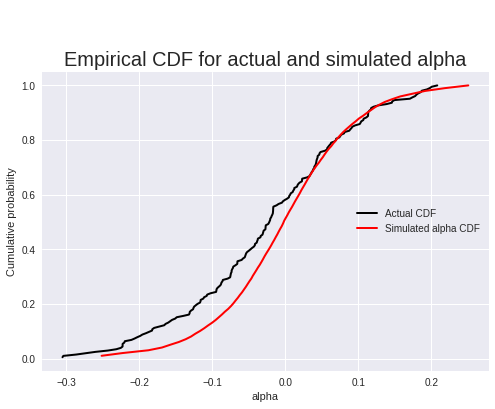

In [56]:
#Generate CDF plot for alphas: 

# compute the ECDF of the samples
qe, pe = ecdf(smpl5)
q, p = ecdf(smpl1)

# evaluate the theoretical CDF over the same range
# q = np.linspace(qe[0], qe[-1], 1000)
# p = n.cdf(q)

# plot
fig, ax = plt.subplots(1, 1)
# ax.hold(True)
ax.plot(q, p, '-k', lw=2, label='Actual CDF')
ax.plot(qe, pe, '-r', lw=2, label='Simulated alpha CDF')
ax.set_xlabel('alpha')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nEmpirical CDF for actual and simulated alpha', fontsize=20)

plt.show()

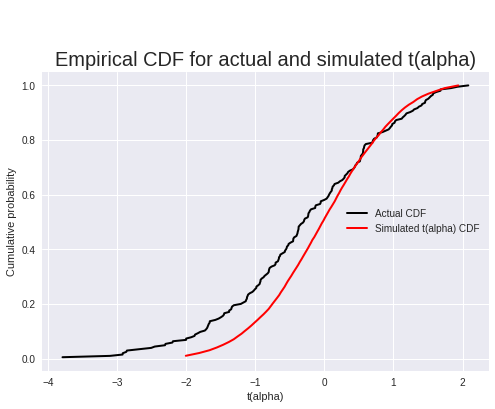

In [57]:

# Generate CDF plot for t(alphas): 
# compute the ECDF of the samples
qe, pe = ecdf(smpl6)
qt, pt = ecdf(smpl3)

# evaluate the theoretical CDF over the same range
# q = np.linspace(qe[0], qe[-1], 1000)
# p = n.cdf(q)

# plot
fig, ax = plt.subplots(1, 1)
# ax.hold(True)
ax.plot(qt, pt, '-k', lw=2, label='Actual CDF')
ax.plot(qe, pe, '-r', lw=2, label='Simulated t(alpha) CDF')
ax.set_xlabel('t(alpha)')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nEmpirical CDF for actual and simulated t(alpha)', fontsize=20)

plt.show()

Text(0.5, 1.0, '\n\nDistribution of t(alpha) simulations')

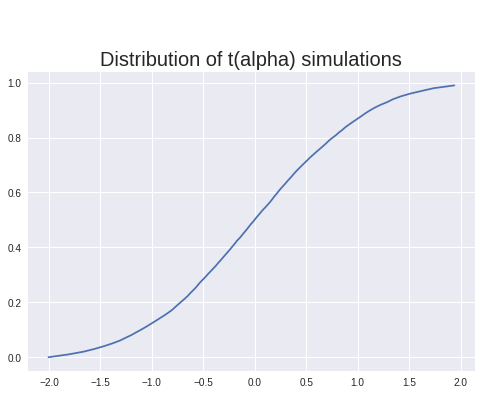

In [58]:
plt.plot(np.sort(smpl6), np.linspace(0, 1, len(smpl6), endpoint=False))
plt.title('\n\nDistribution of t(alpha) simulations', fontsize=20)

In [59]:
sim_coeffs.shape, sim_coeffs[0,:,:]

((4, 205, 100),
 array([[-0.05708426,  0.01618049, -0.01802092, ..., -0.02821799,
          0.14665144,  0.00333725],
        [-0.12743835, -0.08017484, -0.14080035, ..., -0.03200312,
          0.04432746,  0.07691286],
        [-0.02025908, -0.0047036 , -0.11773169, ..., -0.02873221,
          0.08860911,  0.05609989],
        ...,
        [-0.22564162,  0.07529386, -0.01776688, ..., -0.017381  ,
          0.22093859,  0.06421377],
        [-0.21894824,  0.08812437,  0.0032218 , ..., -0.02925148,
          0.21706346,  0.05880602],
        [-0.18558189, -0.01223472, -0.07298078, ...,  0.11694498,
          0.05067387,  0.05211623]]))

In [60]:
#np.percentile(sim_coeffs[0,:,:])
# arr_sorted = sim_coeffs
# arr_sorted[0,:,:]
np.nanmean(np.percentile(sim_coeffs[0,:,:], prct, axis=0), axis=1), sim_coeffs[0,:,:], np.percentile(sim_coeffs[0,:,:], prct, axis=0)

(array([-0.25174363, -0.2226972 , -0.18757666, -0.16893404, -0.15761343,
        -0.14589426, -0.13653909, -0.12904046, -0.12329805, -0.11676481,
        -0.11103602, -0.10582156, -0.10024591, -0.09532277, -0.09097953,
        -0.08669185, -0.08272667, -0.07826352, -0.07452838, -0.07118849,
        -0.06823467, -0.0651289 , -0.0623744 , -0.0593182 , -0.05672252,
        -0.05406153, -0.05165795, -0.04921335, -0.04655268, -0.04451581,
        -0.04212863, -0.03976612, -0.03748277, -0.03495337, -0.03273304,
        -0.03059576, -0.02857007, -0.02634029, -0.02397866, -0.02164127,
        -0.01943143, -0.01738723, -0.01517923, -0.01315188, -0.01100341,
        -0.00909482, -0.00705061, -0.00486559, -0.00305134, -0.00147736,
         0.00065252,  0.00280884,  0.0047549 ,  0.00697461,  0.00924834,
         0.01130759,  0.01336854,  0.01559703,  0.01782188,  0.01995385,
         0.02191838,  0.02411154,  0.02634014,  0.02847202,  0.03063561,
         0.03300669,  0.03522701,  0.03766842,  0.0

## 7. Generating Kernel smoothing density estimate plots

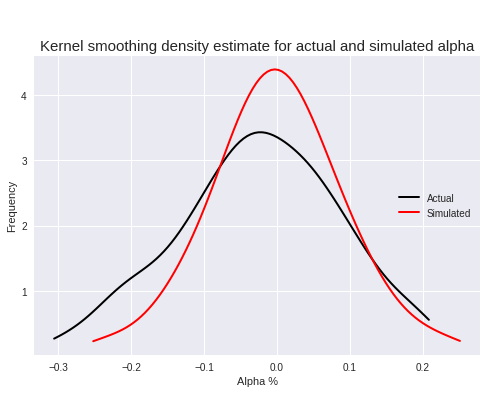

In [61]:
#   Generate Kernel smoothing density estimate plot for alphas: 
#   figure('name','Kernel smoothing density estimate for actual and simulated alpha'); 
#   title('Kernel smoothing density estimate for actual and simulated alpha')
#   hold on [ksd_orig_a, x1] = ksdensity(orig_coefs(1,:)*100); 
#   [ksd_sim_a, x2] = ksdensity(mean(prctile(permute(sim_coefs(1,:,:),[2 3 1]),(100*0.5/ii:100/ii:100-50/ii),1),2)*100); 
#   plot(x1, ksd_orig_a,'Black-',x2, ksd_sim_a,'--Black'); 
#   hold off legend('Actual','Simulated','Location','NW') 
#   xlabel('alpha(%)') % x-axis label ylabel('Frequency') 
#   % y-axis label clear ksd_orig_a x1 ksd_sim_a x2;   

 
kde1 = stats.gaussian_kde(smpl1)
kde2 = stats.gaussian_kde(smpl5)
x1 = np.linspace(smpl1.min(), smpl1.max(), 100)
x2 = np.linspace(smpl5.min(), smpl5.max(), 100)
p1 = kde1(x1)
p2 = kde2(x2)

fig, ax = plt.subplots(1, 1)
# ax.hold(True)
ax.plot(x1, p1, '-k', lw=2, label='Actual')
ax.plot(x2, p2, '-r', lw=2, label='Simulated')
ax.set_xlabel('Alpha %')
ax.set_ylabel('Frequency')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nKernel smoothing density estimate for actual and simulated alpha', fontsize=15)

plt.show()

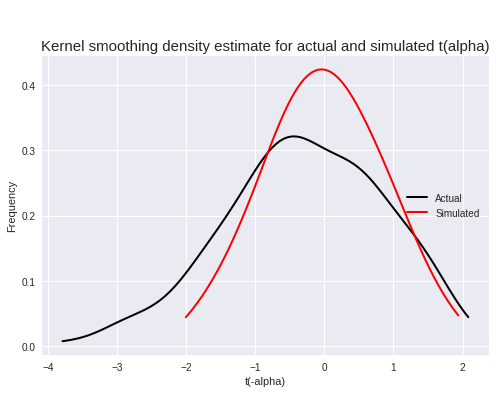

In [62]:
#   Generate Kernel smoothing density estimate plot for t-stats of alpha: 
#   figure('name','Kernel smoothing density estimate for actual and simulated t(alpha)'); 
#   title('Kernel smoothing density estimate for actual and simulated t(alpha)') 
#   hold on [ksd_orig_t, x1] = ksdensity(orig_t_stats(1,:)); 
#   [ksd_sim_t, x2] = ksdensity(mean(prctile(permute(sim_t_stats(1,:,:),[2 3 1]),(100*0.5/ii:100/ii:100-50/ii),1),2)); 
#   plot(x1, ksd_orig_t,'Black-',x2, ksd_sim_t,'--Black'); 
#   hold off legend('Actual','Simulated','Location','NW') 
#   xlabel('t(alpha)') 
#   % x-axis label ylabel('Frequency') 
#   % y-axis label clear ksd_orig_t x1 ksd_sim_t x2; 


kde3 = stats.gaussian_kde(smpl3)
kde4 = stats.gaussian_kde(smpl6)
x3 = np.linspace(smpl3.min(), smpl3.max(), 100)
x4 = np.linspace(smpl6.min(), smpl6.max(), 100)
p3 = kde3(x3)
p4 = kde4(x4)

fig, ax = plt.subplots(1, 1)
# ax.hold(True)
ax.plot(x3, p3, '-k', lw=2, label='Actual')
ax.plot(x4, p4, '-r', lw=2, label='Simulated')
ax.set_xlabel('t(-alpha)')
ax.set_ylabel('Frequency')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nKernel smoothing density estimate for actual and simulated t(alpha)', fontsize=15)

plt.show()

## 8. Generating histograms

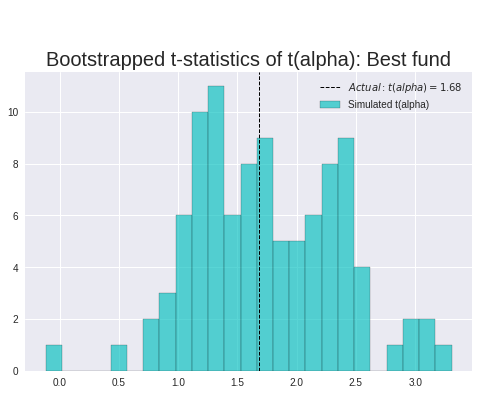

In [63]:
from matplotlib.patches import Rectangle
temp_input = 14
temp_t = np.vstack(percentiles_orig_t)[temp_input]
# hist_data = np.percentile(sim_t_stats[0,:,:].flatten()
result = plt.hist(temp_percentiles_sim_t[temp_input,:][~np.isnan(temp_percentiles_sim_t[temp_input,:])], bins=25, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.vstack(percentiles_orig_t)[temp_input], color='k', linestyle='dashed', linewidth=1)
plt.title('\n\nBootstrapped t-statistics of t(alpha): Best fund', fontsize=20)
# np.vstack(percentiles_orig_t)
# handles = [['---'],  Rectangle((0,0),1,1,color='c')]
# labels= ['Actual t(alpha) = str(temp_t)', 'Simulated t(alpha)']
labels= ['$Actual: t(alpha) = {0:.2f}$'.format(float(temp_t)), 'Simulated t(alpha)']
plt.legend(labels)
# plt.plot(x, y, label='y = %.2f x + %.2f' %(A, B))
# plt.plot(x, y, label='y = {0:.2f} x + {1:.2f}'.format(A,B))
# ax.plot(x, i * x, label='$y={}x$'.format(i))


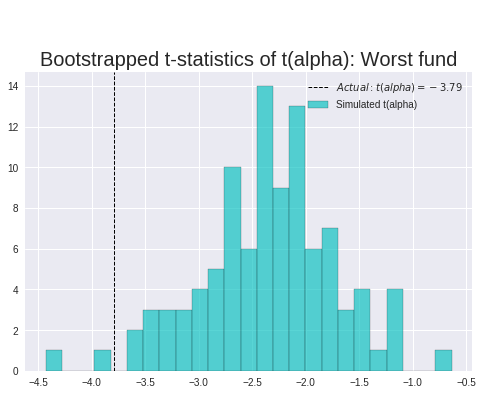

In [64]:
from matplotlib.patches import Rectangle
temp_input = 0
temp_t = np.vstack(percentiles_orig_t)[temp_input]
result = plt.hist(temp_percentiles_sim_t[temp_input,:][~np.isnan(temp_percentiles_sim_t[temp_input,:])], bins=25, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.vstack(percentiles_orig_t)[temp_input], color='k', linestyle='dashed', linewidth=1)
plt.title('\n\nBootstrapped t-statistics of t(alpha): Worst fund', fontsize=20)
labels= ['$Actual: t(alpha) = {0:.2f}$'.format(float(temp_t)), 'Simulated t(alpha)']
plt.legend(labels)


In [0]:
# np.vstack(percentiles_orig_t)[14]
# np.percentile(sim_t_stats[0,:,:], [99], axis=0)
# np.percentile(sim_t_stats[0,:,:], [99], axis=0).flatten()
# temp_percentiles_sim_t[14,:][~np.isnan(temp_percentiles_sim_t[14,:])]
# np.vstack(percentiles_orig_t)[0]

In [0]:
#Generate histogram of simulated t(alpha)'s for various ranks/percentiles:
#Includes vertical line representing the actual performance of fund at
#equivalent rank/percentile:
#Different index INPUTS used to make histograms from
#'temp_percentiles_sim_t' and vertical lines from 'percentiles_orig_t'
#represent different ranks/percentiles to extract, as specified below:
#input: 1:5 - represents ranks: 101(worst):-1:97
#input: 6:14 - represents percentiles 10:10:90
#input: 15:19 - represents ranks 5:-1:1(best))

#BEST FUND
# figure('name','Bootstrapped t-statistics of t(alpha): Best fund');
# title('Bootstrapped t-statistics of t(alpha): Best fund','FontSize',16)
# hold on
# % plot_orig = cdfplot(orig_coefs(1,:));
# temp_input = 19; % SET INPUT value chosen from table at top
# line_hight = 900; % ADJUST this to just above max of highest bar
# line([percentiles_orig_t(temp_input) percentiles_orig_t(temp_input)],[0 line_hight],'LineWidth',2,'Color','Black','LineStyle','--');
# plot_sim = histogram(temp_percentiles_sim_t(temp_input,:),...
# 'BinLimits',[0.5,7]); % Adjust max/min values here (start with large numbers to see range)
# hold off;
# plot_sim.FaceColor = 'k'; plot_sim.EdgeColor = 'k';
# xlabel('t(alpha)','FontSize',14) % x-axis label
# ylabel('Frequency','FontSize',14) % y-axis label
# legend({['Actual t(alpha) = ' num2str(percentiles_orig_t(temp_input))],'Simulated t(alpha)'},...
# 'Location','NE','FontSize',14); % legend font size.
# clear plot_sim temp_input

# 


In [66]:
sim_smaller_t.shape

(19,)

## 9. Loop through simulation program to inject alpha with different standard deviation assumptions

In [67]:
# Construct simulated series based on "sim_indices"
# tic; % Begin timer
# This script used the simulated index numbers to:
# 1) Pick corresponding numbers from factors and residuals, and
# 2) Construct series of fund returns (potentially including injected alpha)
# 3) Series are "alpha free" if 'std_alpha' below is set to '0'.

# The constructed returns will be the basis for new regressions to
# calculate simulated alphas.

# From before: n = total number of funds
# % h = total number of factors
# % m = total number of time periods
# % s = total number of simulations, s = 1 here refers sim #1

# Check if the value for annual "average" standard deviation is already
# defined. If it is, dont't touch it. If it isn't, define a chosen
# value (usually '0') below. We do this to avoid overriding the std of alpha
# in the loop running through different values of std of alpha

for std in [std/4 for std in range(0,15)]:
  try: annual_std_alpha
  except NameError: annual_std_alpha = None

  if annual_std_alpha is None:
    annual_std_alpha = 0 #Set it's value
  else:
      pass
  annual_std_alpha = std
  std_alpha = annual_std_alpha/np.sqrt(12)  
  annual_std_alpha, std_alpha
  temp_avg_orig_std_resid = np.nanmean(orig_SE_resid.values)
  temp_std_resid_ratio = np.divide(orig_SE_resid,temp_avg_orig_std_resid)
  adj_n = Y_all.shape[1]
  temp_alpha = std_alpha*np.tile(np.random.randn(1,adj_n,s) * np.tile(temp_std_resid_ratio,(1,1,s)).reshape((1,adj_n,s), order='F'),(m,1,1))
  orig_betas = orig_coeffs_rank_a.transpose().values[1:4,:]
  constructed_resids = np.empty((m,adj_n,s))*np.nan
  constructed_Y_all = np.empty((m,adj_n,s))*np.nan
  for ss in range(s):
    constructed_X_mat[:,:,ss] = X_mat.values[:,1:4][sim_indices[:,ss],:]  #randomized simulations of Fama-French risk factors: Mkt-RF, SMB, HML
    constructed_resids[:,:,ss] = orig_resids[sim_indices[:,ss],:]  #randomized simulations of residuals from Fama-French equations
    constructed_Y_all[:,:,ss] = temp_alpha[:,:,ss] + np.matmul(constructed_X_mat[:,:,ss], orig_betas) + constructed_resids[:,:,ss] #simulated returns based on fund betas, randomized resids and alphas (0?)
# constructed_Y_all[0,:], constructed_X_mat[0,:], constructed_resids[0,:], constructed_Y_all.shape
#Script that does bootstrap regression results for all funds.

# Set minumum number of observations(n) required in simulation for the
# regression to be valid:
  sim_cutoff = 15
# Populate target output vectors to be filled in with loop:
  sim_SE_resid = np.empty((h+1,adj_n,s))*np.nan
  sim_coeffs = np.empty((h+1,adj_n,s))*np.nan
  # Calculate number of observations per fund per simulation for future
  # reference:
  n_i_s = (~np.isnan(constructed_Y_all)).sum(0)
  # Calculate the lag selection parameter for the standard Newey-West HAC
  # estimate (Andrews and Monohan, 1992), one number per fund per simulation:
  maxLag_s = np.floor((4*(n_i_s/100)**(2/9))).astype(int)
  #Set up regression function with Newey-West Standard Errors (HAC)
  def ols_s(left_side, right_side, maxLag_temp):
    result = sm.OLS(left_side, right_side, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':maxLag_temp})
    return result
#   xa = sm.add_constant(constructed_X_mat[:,:,0])
#   ya_sample = constructed_Y_all[:,0,0]
#   lma = ols_s(ya_sample, xa,2)
  # Loop through each simulation run:
  for ss in range(s):
  #Loop through each fund:
    for jj in range(adj_n):
      if n_i_s[jj,ss]>= sim_cutoff:
        xa = sm.add_constant(constructed_X_mat[:,:,ss])
        ya_sample = constructed_Y_all[:,jj,ss]
        maxLag_temp = maxLag_s[jj,ss]
      
      # linear regression
        lma = ols_s(ya_sample, xa, maxLag_temp)
        sim_SE_resid[:,jj,ss] = .300
        sim_SE_resid[:,jj,ss] = lma.bse
        sim_coeffs[:,jj,ss] = lma.params
  sim_t_stats = np.divide(sim_coeffs,sim_SE_resid)
  percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
  #Sort original alphas and t-values in order to extract top/bottom ranked values:
  temp_sorted_orig_a =  orig_coeffs.take([0], axis=0).sort_values(by=['Alpha'], axis=1, ascending = [0])
  temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
  temp_sorted_orig_a, temp_sorted_orig_t, type(temp_sorted_orig_t)
  percentiles_orig_at = [temp_sorted_orig_a.transpose().tail(5).iloc[::-1], \
                         temp_sorted_orig_a.transpose().quantile(percentages),\
                         temp_sorted_orig_a.transpose().head(5).iloc[::-1]]
  temp1t = temp_sorted_orig_t.transpose().tail(5)
  temp2t = temp_sorted_orig_t.transpose().quantile(percentages)
  temp3t = temp_sorted_orig_t.transpose().head(5)
  percentiles_orig_t = [temp1t, temp2t, temp3t]
  percentiles_orig_a = np.empty(2, dtype=float)
  percentiles_orig_a = [temp_sorted_orig_a.transpose().tail(5).iloc[::-1],temp_sorted_orig_a.transpose().quantile(percentages),temp_sorted_orig_a.transpose().head(5).iloc[::-1]]
  percentiles_orig_t = np.empty(2, dtype=float)
  percentiles_orig_t = [temp_sorted_orig_t.transpose().tail(5).iloc[::-1], temp_sorted_orig_t.transpose().quantile(percentages),temp_sorted_orig_t.transpose().head(5).iloc[::-1]]
  temp_sort_desc_sim_a = np.sort(sim_coeffs[0,:,:].transpose(), axis=1)[:,::-1]
  temp_sort_asc_sim_a = np.sort(sim_coeffs[0,:,:].transpose(), axis=1)
  temp_sort_desc_sim_t = np.sort(sim_t_stats[0,:,:].transpose(), axis=1)[:,::-1]
  temp_sort_asc_sim_t = np.sort(sim_t_stats[0,:,:].transpose(), axis=1)
  percentages1 = [10,20,30,40,50,60,70,80,90]
#   np.percentile(sim_coeffs[0,:,:].transpose(), percentages1, axis = 1).shape
  temp_percentiles_sim_a = np.concatenate((temp_sort_asc_sim_a.transpose()[0:5,:], \
                           np.percentile(sim_coeffs[0,:,:].transpose(), percentages1, axis = 1), \
                           temp_sort_desc_sim_a.transpose()[0:5,:][::-1]))
  temp_percentiles_sim_t = np.concatenate((temp_sort_asc_sim_t.transpose()[0:5,:], \
                           np.percentile(sim_t_stats[0,:,:].transpose(), percentages1, axis = 1), \
                           temp_sort_desc_sim_t.transpose()[0:5,:][::-1]))
  mean_percentiles_sim_a = np.nanmean(temp_percentiles_sim_a, axis=1)
  mean_percentiles_sim_t = np.nanmean(temp_percentiles_sim_t, axis=1
  sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),(1,s)), axis=1)/s*100
  sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),(1,s)), axis=1)/s*100
# sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),(1,s)), axis=1)/s*100
# sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),(1,s)), axis=1)/s*100
  table_a1=pd.DataFrame(data=np.vstack(percentiles_orig_a))
  table_a2=pd.DataFrame(data=mean_percentiles_sim_a)
  table_a3=pd.DataFrame(data=sim_smaller_a)
  table_a4=pd.concat([table_a1, table_a2, table_a3], axis=1)
  table_a4.columns=['Actual','Sim Avg', '%<Act']
  idx=['Worst',	'2nd',	'3rd', '4th', '5th', '10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'5th', '4th', '3rd', '2nd', 'Best']
  se=pd.Series(idx)
  table_a4['Rank/pctl']=se.values
  table_a = table_a4.set_index('Rank/pctl')
  table_t1=pd.DataFrame(data=np.vstack(percentiles_orig_t))
  table_t2=pd.DataFrame(data=mean_percentiles_sim_t)
  table_t3=pd.DataFrame(data=sim_smaller_t)    
  table_t4=pd.concat([table_t1, table_t2, table_t3], axis=1)
  table_t4.columns=['Actual','Sim Avg', '%<Act']
#     idx=['Worst',	'2nd',	'3rd',	'10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'3rd',	'2nd',	'Best']
  set=pd.Series(idx)
  table_t4['Rank/pctl']=set.values
  table_t = table_t4.set_index('Rank/pctl')
  t_index = [std/4 for std in range(0,15)]
  data = pd.DataFrame([], index=idx, columns=t_index)
#     if std=0:
  data.loc[:,std]=table_t['Sim Avg']
                                        
                                        
                                        
    # Clear 'excess' variables no longer needed: 
  del percentages
  del temp_sort_desc_sim_a 
  del temp_sort_asc_sim_a
  del temp_sort_desc_sim_t 
  del temp_sort_asc_sim_t
  del mean_percentiles_sim_a 
  del mean_percentiles_sim_t
  del sim_smaller_a 
  del sim_smaller_t
  del table_t
  del table_a
                                        
                                        
                                        
# data = pd.DataFrame([])

# for i in np.arange(0, 4):
#     if i % 2 == 0:
#         data = data.append(pd.DataFrame({'A': i, 'B': i + 1}, index=[0]), ignore_index=True)
#     else:
#         data = data.append(pd.DataFrame({'A': i}, index=[0]), ignore_index=True)

# print(data.head())                                        
    
  
    

    
    
    
  
  


 

SyntaxError: ignored

In [0]:
t_index = [std/4 for std in range(0,15)]
t_index

In [0]:
# A=2*np.arange(4)[:, None]/np.arange(1,5)
# A
t_index = [std/4 for std in range(0,15)]
idx=['Worst',	'2nd',	'3rd', '4th', '5th', '10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'5th', '4th', '3rd', '2nd', 'Best']
data = pd.DataFrame([], index=idx, columns=t_index)
data.insert(0, 'Actual', float(1))

# for i in np.arange(0, 4):
#     if i % 2 == 0:
#         data = data.append(pd.DataFrame({'A': i, 'B': i + 1}, index=[0]), ignore_index=True)
#     else:
#         data = data.append(pd.DataFrame({'A': i}, index=[0]), ignore_index=True)

# print(data.head(5))
data.head(5), data.columns, data.index, data.loc[:,float(1.5)]